# Grappa Student Seminar
### Weekly programming assignments - Week 2
#### Dylan van Arneman, Gijs Leguijt, Sven Poelmann, Yoran Yeh
##### June 2019 

[Github link](https://github.com/adam-coogan/GRAPPA_Student_Seminar_2019)


## Imports 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import *
from scipy.optimize import root
from scipy.integrate import *
from scipy.interpolate import interp1d
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline


## Units & constants

In [2]:
"""Units________________________________________________________________________________________________________________"""
eV      = 1                                                                                                  #Electron volt
J       = eV / e                                                                                                     #Joule
s       = 1 / (hbar * J)                                                                                            #Second
m       = s / c                                                                                                      #Meter
kg      = J * c**(2)                                                                                             #Kilograms
K       = J * k                                                                                                     #Kelvin

"""Constants____________________________________________________________________________________________________________""" 

G       = value("Newtonian constant of gravitation") * (m**3 / (kg * s**2))                                #Newton constant
M_pl    = value('Planck mass') * kg                                                                            #Planck mass
M_sun   = 1.989e30 * kg                                                                                         #Solar mass
GeV     = 1.0e9 * eV                                                                                    #Giga electron volt
MeV     = 1.0e6 * eV                                                                                    #Mega electron volt
G_f     = value('Fermi coupling constant') * GeV**-2                                                        #Fermi constant
T_CMB   = 2.725 * K                                                                                        #CMB temperature
pc      = 3.085e16 * m                                                                                              #Parsec
kpc     = 1.0e3 * pc                                                                                           #Kilo parsec
Mpc     = 1.0e6 * pc                                                                                           #Mega parsec
km      = 1.0e3 * m                                                                                               #Kilomter
cm      = 1.0e-2 * m                                                                                            #Centimeter
H       = 67.8 * (km / s) / Mpc                                                                           #Hubble constant
h_hub   = H / (1.0e5 * (m / s) / Mpc)                                                              #Reduced hubble constant
rho_c   = 1.9e-26 * h_hub**2 * kg / m**3                                                                  #Critical density
zheta_3 = 1.202                                                                              #Zheta funtion with argument 3

## Tasks
In this notebook we determine the J-factor of the Milky Way. We tackle three main tasks:

   1) Estimate $r_s$ and $\rho_s$ for the Milky Way halo.
   
   2) Determining $\frac{d J}{d \Omega}$ as a funciton of the angle $\psi$ .
   
   3) Determine $J$ around the Galactic center within 0.5 degrees.


## Task 1: Estimating Galactic parameters

In order to calculate the J-factor, we need to use the NFW density profile:

$$ \rho(r) = \frac{ \rho_s}{\left(r/r_s\right) \left(r/r_s+1\right)^2}. $$

Here the characteristic density, $\rho_s$, is given by

$$ \frac{M}{4 \pi r_s^3 \left[ \ln(1+c_{\rm vir}) - c_{\rm vir}{\large/}(1+c_{\rm vir}) \right]}, $$

the scale radius is given by 

$$ r_s = \frac{r_{\rm vir}}{c_{\rm vir}} $$

and the virial radius is given by 

$$ r_{\rm vir} = \left( \frac{3 M}{4 \pi \Delta_{\rm vir}(z) \rho_c(z)}\right)^{1/3}. $$

The starting values are given in the cell below.

In [3]:
Delta = 18 * np.pi**2                                                             #Overdensity halos compared to background
c_vir = 10                                                                                              #Halo concentration
M     = 1.0e12 * M_sun                                                                                      #Mass of galaxy
d_gal = 8178 * pc                                                                              #Distance to galactic center

In [4]:
def f_rvir(M):
    """Calculates virualised radius
    Input: single value, output: single value"""
    return (3 * M / (4 * np.pi * Delta * rho_c))**(1./3)

def f_rs(M):
    """Calculates scale radius
    Input: single value, output: single value"""
    return f_rvir(M) / c_vir

def f_rhos(M):
    """Calculates density normalisation factor
    Input: single value, output: single value"""
    return M / (4 * np.pi * f_rs(M)**3 * (np.log(1 + c_vir) - c_vir / (1 + c_vir)))

In [5]:
r_s = f_rs(M)                                                                                                 #Scale radius
r_vir = f_rvir(M)                                                                                        #Virualised radius
rho_s = f_rhos(M)                                                                                    #Density normalisation

In [6]:
def rho(r,r_s = r_s,rho_s = rho_s):
    """Calculates density profile
    Input: 1D array, output: 1D array"""
    x = r/r_s
    return rho_s / (x * (x+1)**2)

In [7]:
print('rho_s= %s'%(f_rhos(M) / GeV * cm**3))
print('Virial radius = %s'%(f_rvir(M)/kpc))
print('Scale radius = %s'%(f_rs(M)/kpc))

rho_s= 0.19487555592113343
Virial radius = 218.43981992522706
Scale radius = 21.843981992522703


## Task 2: Determine differential J-factor

In this part we determine the diffrerential J-factor by solving the following line-of-sight integral:

$$ \frac{d J}{d \Omega}  = \int d l \rho^2(r(l,\Omega)).$$

Since this is an intgral over the line-of-sight, $l$, and not the radius, $r$, we need to rewrite some of the variables.

Do this using the law of cosines:

$$ r^2 = d^2 + l^2 + 2d l \cos \theta  ,$$

where $d$ is the distance between us (earth) and the Galactic center.

In [8]:
def f_rl(l,psi,d=d_gal):
    """Calculates r as a function of line of sight
    Input: 1 array and 1 single value, output: array"""
    return np.sqrt(l**2 + d**2 - 2 * d * l * np.cos(psi))

def integrand(l,psi):
    """Integrand of dJ/dOmega, to be integrated over dl
    Input: 1 array and 1 single value, output: 1D array""" 
    r = f_rl(l,psi)
    return rho(r)**2

def dJdO(psi,d=d_gal):
    """Calculates dJ/dOmega by integration over dl
    Input: single value, output: single value"""
    l_min = 0
    l_max = 10 * d
    return quad(integrand,l_min,l_max,args=(psi,))
#domega = 2pi sinpsi dpsi
def dJdpsi(psi,d=d_gal):
    """Returns dJ/dpsi
    Input: single value, output: single value"""
    return dJdO(psi)[0] * 2 * np.pi #* np.sin(psi)

Now we solve this integral for various values of the angle $\psi.$

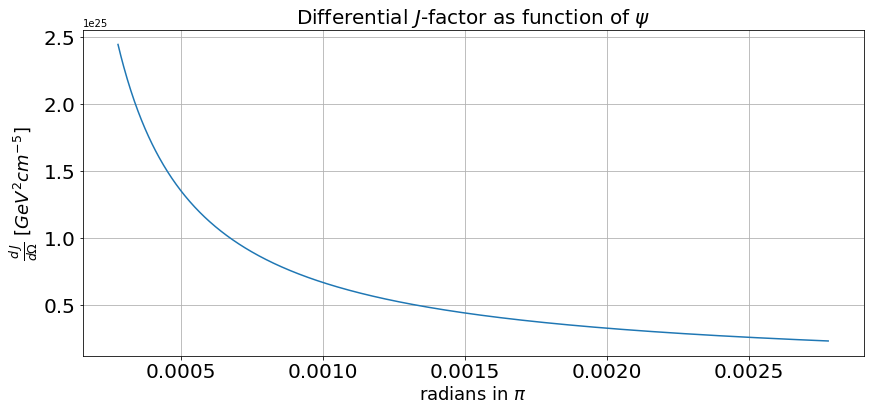

In [9]:
arr_psi=np.linspace(np.pi/3600,np.pi/360,1000)                            #Angles close to galactic center up to 45 degrees
L_dJdO = []                                                                       #List to contain dJ/dOmega for all angles

for psi in arr_psi:                                                                   #Calculating dJ/dOmega for all angles
    dJ=dJdO(psi)
    L_dJdO.append(dJ[0])
arr_dJdO = np.asarray(L_dJdO)

plt.figure(1,figsize=(14, 6))                                                                       #Plot showing dJ/dOmega
plt.plot(arr_psi/np.pi,arr_dJdO*cm**5/GeV**2)
plt.xlabel(r'radians in $\pi$',fontsize = 18)
plt.ylabel(r'$\frac{d\>J}{d\Omega}$ $[GeV^2cm^{-5}]$',fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(r'Differential $J$-factor as function of $\psi$ ', fontsize=20)
plt.grid(True)
plt.show()

## Task 3: Calculating the J-factor

Now we determine the J-factor by including the solid angle in our calculation. As the problem is spherically symmetric, the conversion from $\frac{dJ}{d\Omega}$ to $\frac{dJ}{d\psi}$ is simply adding a factor of $2\pi$.

To avoid insensible calculations at $\psi = 0$, we integrate from a minimum angle outward to the desired angle. Thus creating an integrated cone, with a tiny cone missing in the middle.

By reducing the minimum angle, the part missing from the integrated cone becomes smaller, up to the point where reducing the minimum angle further yields problems with integration. To find a value for the full integrated cone, we extrapolate our calculation to $\psi_{min} = 0$.

C:\Users\G\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\G\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


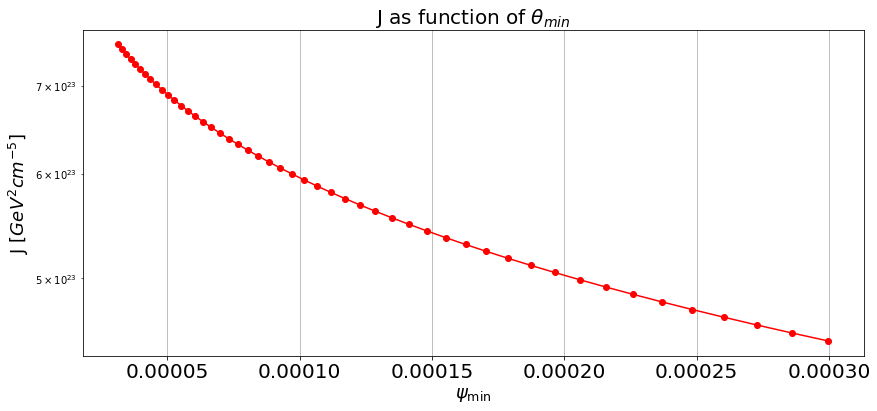

In [10]:
L_J = []                                                                                      #List to contain values for J
divisions = np.logspace(np.log10(1.0e4),np.log10(1.0e5),50)                   #Array to set multiple values for minimal psi
psi_min = np.pi / divisions                                           #Setting minimum angle, close to center of the galaxy
for angle in psi_min:
    L_J.append(quad(dJdpsi,angle,np.pi/360)[0]*(cm**5)/(GeV**2))

plt.figure(1,figsize=(14, 6))        #Figure plotting integral of J 0.5 degrees from galactic center, varying minimal angle
plt.semilogy(psi_min[1:], L_J[1:], 'r-o')
plt.xlabel(r'$\psi_{\rm min}$',fontsize = 18)
plt.ylabel(r'J $[GeV^2cm^{-5}]$',fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(r'J as function of $\theta_{min}$ ', fontsize=20)
plt.grid(True)
plt.show()

In [11]:
def poly(x_fit,y_fit,deg,x):
    """Fits a polynomial through the data
    Input: 2 1D arrays, 1 single value and 1D array, output: 1D array"""
    output = 0
    fit = np.polyfit(x_fit,y_fit,deg)
    for i in range(deg+1):
        output += fit[i] * x**(deg-i)
    return output

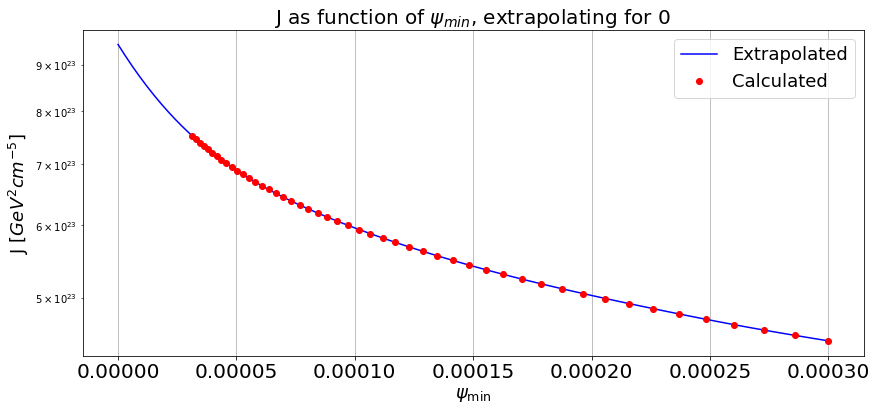

In [12]:
psi = np.linspace(0,0.0003,100)                                                     #Setting a linespace for minimum angles

plt.figure(1,figsize=(14, 6))         #Figure plotting integral of J 0.5 degrees from galactic center, extrapolated to zero
plt.semilogy(psi, poly(psi_min,L_J,7,psi), 'b-',label = 'Extrapolated')
plt.semilogy(psi_min[1:], L_J[1:], 'ro',label = 'Calculated')
plt.xlabel(r'$\psi_{\rm min}$',fontsize = 18)
plt.ylabel(r'J $[GeV^2cm^{-5}]$',fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(r'J as function of $\psi_{min}$, extrapolating for 0 ', fontsize=20)
plt.legend(prop=dict(size=18))
plt.grid(True)

In [13]:
final_value = poly(psi_min,L_J,7,psi)[0] / 1.0e23
print ('As a final value for J we find: %.2f e23 GeV^2 cm^-5' % final_value)

As a final value for J we find: 9.47 e23 GeV^2 cm^-5
